## Path to data folder

This section indicates which data will be used for the tests.

In [ ]:
# Connect to Colab
from google.colab import drive
drive.mount('/content/drive/')

# Go to the folder containing the data
%cd /content/drive/MyDrive/Projet_A3S5/Donnees/Final_Data

Mounted at /content/drive/
/content/drive/.shortcut-targets-by-id/1VyeGE8G8NemjPGnlHQA2fEjmVxwDsQTS/Projet_A3S5/Donnees/Final_Data


In [ ]:
target_path = "Femur"

## Load metadata

This section loads the metadata, which contain origin, orientation and label (0 for healthy and 1 for pathological) for each image.

In [ ]:
import os
import pandas as pd

# Retrieve metadata
metadata = os.path.join(target_path, 'Metadata.xlsx')
df = pd.read_excel(metadata)
df

,Name,Orientation_pca,Orientation_manual,Label,From_Stanford
0,Femur_01,1,D,1,0
1,Femur_02,1,D,0,0
2,Femur_04,0,G,0,0
3,Femur_06,1,D,1,0
4,Femur_07,1,G,1,0
...,...,...,...,...,...
184,Femur_PHC_243,1,NaN,0,1
185,Femur_PHC_244,0,NaN,0,1
186,Femur_PHC_245,0,G,1,1
187,Femur_PHC_248,0,G,1,1


## Load data

This section retrieves the PATH of the section "Path to folder" to load data, normalises the data and adds the metadata to the images. It is possible to change the size of the inputs by modifying the parameter "n_img" and "p_img" in the reshape function. The size is unchanged here.

In [ ]:
import numpy as np
from tqdm import tqdm
from PIL import Image

In [ ]:
# Paths to images with regex
path_affine = os.path.join(target_path,'Map','Mirror')
paths = np.array([os.path.join(path_affine, name + '.tiff') for name in df['Name']])

# Load images
imgs_aff = []
for path in tqdm(paths):
    imgs_aff.append(np.array(Image.open(path)))
imgs_aff = np.array(imgs_aff)

# Retrieve labels
lbls_aff = df['Label'].to_numpy()
names_aff = df['Name'].to_numpy()
orient_aff = df['Orientation_pca'].to_numpy()

# Convert images to vectors
Nimg, n_img, p_img = imgs_aff.shape
X_aff = np.reshape(imgs_aff, (Nimg,n_img*p_img))
X_aff_c = X_aff - X_aff.mean(axis=0)

100%|██████████| 189/189 [00:50<00:00,  3.75it/s]


## Decompositions / Data Reduction

This section applies the decompositions by using the 3 methods ACP, NMF and TNF.
First, if Tensorly installed it is downloaded. 
The Parameter "Ncomps" indicates the number of components wished for the outputs.

In [ ]:
!pip install tensorly

     |████████████████████████████████| 198 kB 3.2 MB/s 
     |████████████████████████████████| 154 kB 47.5 MB/s 


In [ ]:
from sklearn.decomposition import PCA, NMF
from tensorly.decomposition import parafac2
import tensorly as tl
tl.set_backend('pytorch')

In [ ]:
def NTF(data, Ncomps, Nrun=1):
    tensor = tl.tensor(np.transpose(data, (1,2,0)))
    decomp, best_err = None, np.inf
    for run in range(Nrun):
        trial_decomp, trial_errs = parafac2(tensor, Ncomps, random_state=run, return_errors=True)
        if best_err > trial_errs[-1]:
            decomp, best_err = trial_decomp, trial_errs[-1]

    return decomp, best_err

In [ ]:
# Number of components
Ncomps = 100

# PCA
pca = PCA(Ncomps)
X_pca = pca.fit_transform(X_aff_c)
features_pca = pca.components_

# NMF
nmf = NMF(Ncomps, init='random', max_iter=2000)
X_nmf = nmf.fit_transform(X_aff)
features_nmf = nmf.components_

# NTF (parafac2)
decomp, ntf_err = NTF(imgs_aff, Ncomps)
weights, (A, B, C) = tl.parafac2_tensor.apply_parafac2_projections(decomp)
B = np.array([np.array(b) for b in B])
X_ntf = np.array(C)
feature_ntf = np.array(np.fromfunction(lambda k,i,j : A[i,k] * B[i,j,k], (Ncomps,n_img,n_img), dtype=int))

# Gather results in dict
Xs = dict(PCA=X_pca, NMF=X_nmf, NTF=X_ntf)

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning:

Maximum number of iterations 2000 reached. Increase it to improve convergence.



## Visualize Features

In [ ]:
import matplotlib.pyplot as plt

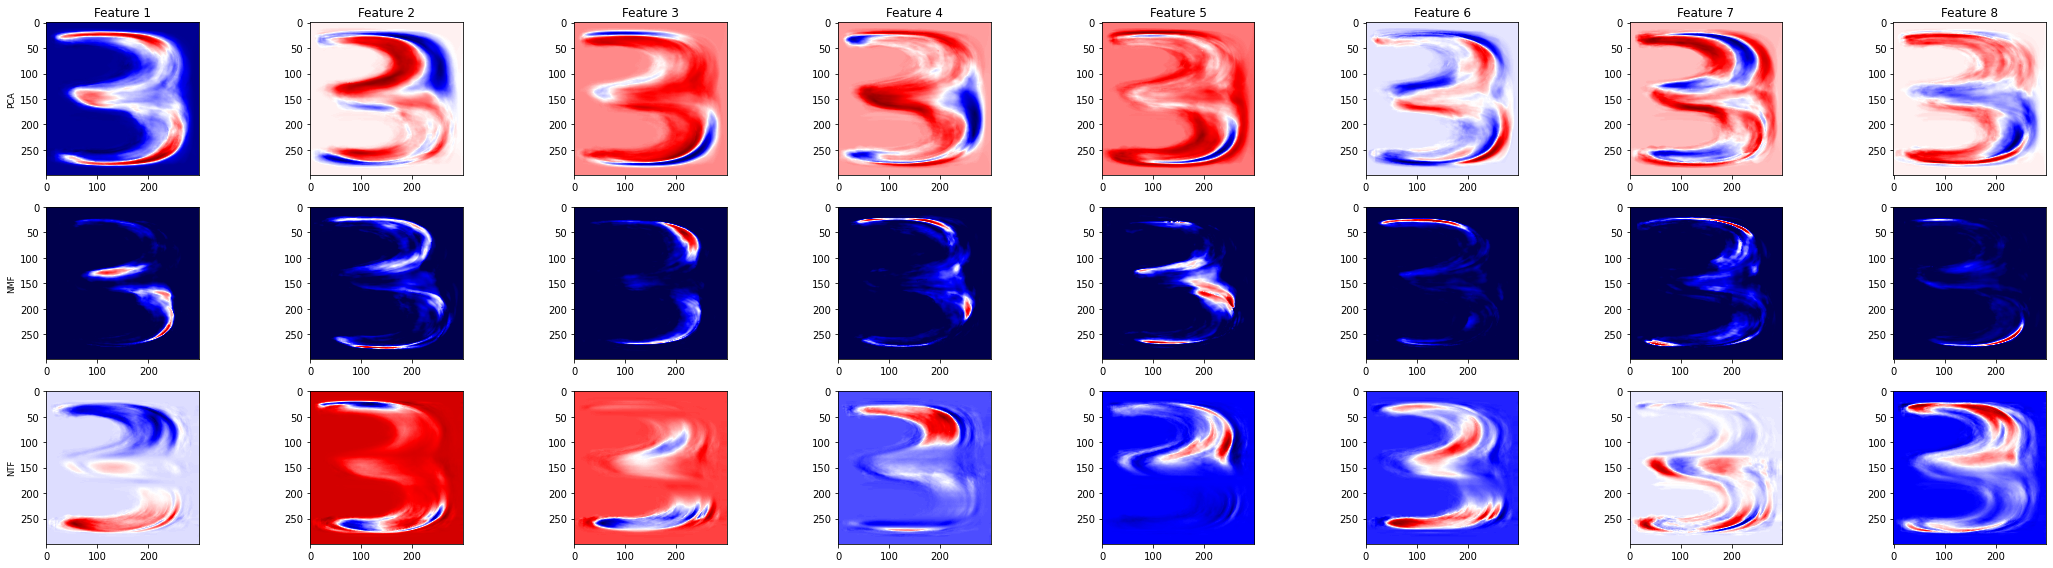

In [ ]:
# Define figure
ncols = 8
fig, axes = plt.subplots(nrows=3, ncols=ncols, figsize=(30,8))

# Set colum names
cols = [f"Feature {i+1}" for i in range(ncols)]
for ax, col in zip(axes[0], cols):
    ax.set_title(col)

# Set row names
rows = ["PCA", "NMF", "NTF"]
for ax, row in zip(axes[:,0], rows):
    ax.set_ylabel(row, rotation=90, size='small')

# Plot features
params = dict(cmap='seismic')
for i in range(ncols):
    axes[0,i].imshow(features_pca[i,:].reshape(n_img,p_img), **params)
    axes[1,i].imshow(features_nmf[i,:].reshape(n_img,p_img), **params)
    axes[2,i].imshow(feature_ntf[i,:], **params)

fig.tight_layout()
plt.show()

## Visualize data in 3D

In [ ]:
import plotly.graph_objects as go
import ipywidgets as widgets
from ipywidgets import interactive

In [ ]:
def f(c1, c2, c3, decomp, colors):
    X = Xs[decomp]
    if colors == 'H / P':
        labels = lbls_aff
        name1, name2 = 'Healthy', 'Pathological'
        color1, color2 = 'cornflowerblue', 'coral'
    else:
        labels = orient_aff
        name1, name2 = 'Side 1', 'Side 2'
        color1, color2 = 'darkorange', 'lime'

    layout = go.Layout(autosize=True, showlegend=True,
        title=f"Visualization of data with 3 components {decomp} ({c1}, {c2}, {c3})",
        scene=go.layout.Scene(
            xaxis=go.layout.scene.XAxis(title=f'Feature {c1}'),
            yaxis=go.layout.scene.YAxis(title=f'Feature {c2}'),
            zaxis=go.layout.scene.ZAxis(title=f'Feature {c3}')
            )
    )

    data = [go.Scatter3d(x=X[labels==0,c1], y=X[labels==0,c2], z=X[labels==0,c3], mode='markers', 
                        marker=dict(size=5, color=color1, opacity=0.9,), text=names_aff[labels==0], name=name1),
            
            go.Scatter3d(x=X[labels==1,c1], y=X[labels==1,c2], z=X[labels==1,c3], mode='markers', 
                    marker=dict(size=5, color=color2, opacity=0.9,), text=names_aff[labels==1], name=name2),
            ]
  
    # Define figure
    fig = go.Figure(data=data, layout=layout)
    fig.show()

slider = lambda v : widgets.IntSlider(min=0, max=Ncomps-1, step=1, value=v)
interactive_plot = interactive(f, c1=slider(0), c2=slider(1), c3=slider(2), decomp=Xs.keys(), colors=['H / P','L / R'])
output = interactive_plot.children[-1]
# output.layout.height = '350px'
interactive_plot.update()
interactive_plot

interactive(children=(IntSlider(value=0, description='c1', max=99), IntSlider(value=1, description='c2', max=9…

## Reconstruction error

In [ ]:
pca_rec = pca.inverse_transform(X_pca)
nmf_rec = nmf.inverse_transform(X_nmf)

pca_err =  np.sqrt(((X_aff_c - pca_rec)**2).sum()) / np.sqrt(sum(np.linalg.norm(x,2)**2 for x in X_aff_c))
nmf_err = np.sqrt(((X_aff - nmf_rec)**2).sum()) / np.sqrt(sum(np.linalg.norm(x,2)**2 for x in X_aff))

print(f"PCA Reconstruction Error = {pca_err}")
print(f"NMF Reconstruction Error = {nmf_err}")
print(f"NTF Reconstruction Error = {ntf_err}")

PCA Reconstruction Error = 0.20461240512991646
NMF Reconstruction Error = 0.1356103254246259
NTF Reconstruction Error = 0.13566674292087555
